# Logistic Regression from the Scratch (Part One)
## Case Study: Determine whether a person makes over 50K a year

The main objective of this notebook is to implement **Logistic Regression** from the scratch. We start this process by deriving negative log likelihood of the Logistic Regression. Then, simple full-batch Gradient Descent algorithm will be used for optimizing negative log likelihood function. Additionally, as a case study, we will show how to design a simple machine learning model for predicting whether a person makes over 50K a year using census data.So key features of this notebook:
* Derive negative log likelihood of the logistic regression.
* Build logistic regression model from the scratch using Python/Numpy.
* Basic building blocks ( written as Python functions) of the logistic regression model will be tested using unit tests.
* Run the logistic regression algorithm against a simple 2D dataset.
* Finally, use our logistic regression algorithm for building a simple yet practical machine learning model.

### Deriving the Gradient for the Logistic Regression
The most common approach to estimating parameters in parametric models is the maximum likelihood estimator. For logistic regression algorithm, we can define maximum likelihood estimator as given below.

\begin{align}
l(\mathbf{w}) = \prod_{i=1}^{N}{P(y_{i} | \mathbf{x}_{i}, \mathbf{w})}
\end{align}
In above equation, $\mathbf{w}$ represents the parameters we would like to estimate by maximizing conditional probability of $\mathbf{y}_i$ given $\mathbf{x}_i$.

Instead of  solving above maximization problem, we would like to take the negative log and framing it as a minimization problem as given below. 
\begin{align}
NLL(\mathbf{w}) = -\sum_{i=1}^{N}ln({P(y_i | \mathbf{x}_i, \mathbf{w})})
\end{align}

We can further expand above equation using two indicator variables $\mathbb{I}(y_{i} = 1) = 1$ and $\mathbb{I}(y_{i} = 0) = 1$.

\begin{align}
NLL(\mathbf{w}) = -\sum_{i=1}^{N}ln((\mathbb{I}(y_{i} = 1){P(y_{i} = 1 | \mathbf{x}_{i}, \mathbf{w})}) + ln(\mathbb{I}(y_{i} = 0){P(y_{i} = 0 | \mathbf{x}_{i}, \mathbf{w})})
\end{align}

Further, by definition of probability in the logistic regression model: ${P(y_{i} = 1 | \mathbf{x}_{i}, \mathbf{w})} = 1 / ( 1 + e^{-\mathbf{w}^{T}\mathbf{x}_{i}})$ and  ${P(y_{i} = 0 | \mathbf{x}_{i}, \mathbf{w})} = e^{-\mathbf{w}^{T}\mathbf{x}_i} / ( 1 + e^{-\mathbf{w}^{T}\mathbf{x}_i})$ and by substituting these expressions into our $NLL(\mathbf{w})$ equation and simplifying it further we can obtain  a simple expression for the derivative of the gradient of the logistic regression.

\begin{align}
NLL(\mathbf{w}) &= -\sum_{i=1}^{N}ln((\mathbb{I}(y_{i} = 1){P(y_{i} = 1 | \mathbf{x}_{i}, \mathbf{w})}) + ln(\mathbb{I}(y_{i} = 0){P(y_{i} = 0 | \mathbf{x}_{i}, \mathbf{w})})) \\
    &= -\sum_{i=1}^{N}\mathbb{I}(y_{i} = 1)ln(\frac{1}{(1 + e^{-\mathbf{w}^{T}\mathbf{x}_i})}) + \mathbb{I}(y_{i} = 0)ln(\frac{e^{-\mathbf{w}^{T}\mathbf{x}_i}}{( 1 + e^{-\mathbf{w}^{T}\mathbf{x}_i})}) \\
    &= -\sum_{i=1}^{N}\mathbb{I}(y_{i} = 1)ln(\frac{1}{(1 + e^{-\mathbf{w}^{T}\mathbf{x}_i})}) + (1-\mathbb{I}(y_{i} = 1))ln(\frac{e^{-\mathbf{w}^{T}\mathbf{x}_i}}{( 1 + e^{-\mathbf{w}^{T}\mathbf{x}_i})}) \\
    &= -\sum_{i=1}^{N}-\mathbb{I}(y_{i} = 1)ln(1 + e^{-\mathbf{w}^{T}\mathbf{x}_i}) + (1-\mathbb{I}(y_{i} = 1))(-\mathbf{w}^{T}\mathbf{x}_i - ln( 1 + e^{-\mathbf{w}^{T}\mathbf{x}_i})) \\
    &= \sum_{i=1}^{N}(1-\mathbb{I}(y_{i} = 1))\mathbf{w}^{T}\mathbf{x}_i + ln(1 + e^{-\mathbf{w}^{T}\mathbf{x}_i})
\end{align}

Next, taking the derivative of $NLL(\mathbf{w})$ w.r.t. $\mathbf{w}$ (and using $\frac{\partial{\mathbf{w}^{T}\mathbf{x}}}{\partial{\mathbf{w}}} = \mathbf{x}$) we can easily find out a simplified equation for the derivative of the negative log likelihood of the logistic regression algorithm.

\begin{align}
\frac{\partial{NLL(\mathbf{w})}}{\partial{\mathbf{w}}} &= \sum_{i=1}^{N}(1-\mathbb{I}(y_{i} = 1))\mathbf{x}_i - \frac{e^{-\mathbf{w}^{T}\mathbf{x}}\mathbf{x}_i}{(1 + e^{-\mathbf{w}^{T}\mathbf{x}_i})} \\
 &= \sum_{i=1}^{N}(1-\mathbb{I}(y_{i} = 1) - 1 + P(y_i = 1 | \mathbf{x}_i, \mathbf{w}))\mathbf{x}_i \\
 &= \sum_{i=1}^{N}(P(y_i = 1 | \mathbf{x}_i, \mathbf{w}) -\mathbb{I}(y_{i} = 1))\mathbf{x}_i
\end{align}

Now we have derived both negative log likelihood function and its derivative w.r.t. w. In the rest of this notebook, we are going to implement these equations in Python and finally we build a simple predictive model for categorizing annual income using a real-world dataset.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import numpy.testing as npt
import matplotlib.pylab as plt
from matplotlib import colors

import seaborn as sns
sns.set(color_codes=True)

from sklearn.datasets.samples_generator import make_blobs

First of all, let's write few helper functions. **`train_test_split`** is used to split training into training and testing subsets and  **`get_k_fold_indices`** is used for doing K-Fold cross-validation. 

In [2]:
def train_test_split(data_set, features, labels, train_fraction = 0.8):
    """
      
    """
    numerical_features = features['numerical']
    categorical_features = features['categorical']
    feature_matrix = None
    
    if len(categorical_features) == 0 :        
        feature_matrix = data_set[numerical_features].values
    elif len(numerical_features) == 0 :
        new_data_frame = pd.concat(pd.get_dummies(data_set[categorical_features]), axis=1)
        feature_matrix = new_data_frame.values
    else:
        new_data_frame = pd.concat([data_set[numerical_features],
                                   pd.get_dummies(data_set[categorical_features])], axis=1)
        feature_matrix = new_data_frame.values
        
    lables_array = data_set[labels].values    
    
    shuffled_indices = np.linspace(0, lables_array.shape[0]-1, lables_array.shape[0], dtype=int)    
    np.random.shuffle(shuffled_indices)
    
    feature_matrix = feature_matrix[shuffled_indices, :]
    lables_array = lables_array[shuffled_indices]
    
    train_upper_limit = (int)(lables_array.shape[0]*train_fraction)
    
    train_features = feature_matrix[0:train_upper_limit, :]
    train_labels = lables_array[0:train_upper_limit]
    
    test_features = feature_matrix[train_upper_limit:, :]
    test_labels = lables_array[train_upper_limit:]
    
    return (train_features, train_labels, test_features, test_labels)

In [3]:
## running some test cases
test_data = {'feature_1': pd.Series([1,2,3,4,5,6,7,8,9,10]),
             'feature_2': pd.Series([11,12,13,14,15,16,17,18,19,20]),
              'label' :  pd.Series([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])}
test_frame = pd.DataFrame(test_data)
np.random.seed(1024)

test_features = {'numerical': ['feature_1', 'feature_2'], 'categorical' :[]}
t1, t2, t3, t4 = train_test_split(test_frame,test_features , 'label', 0.8)
assert t1.shape[0] == 8 and t2.shape[0] == 8 and \
       t3.shape[0] == 2 and t4.shape[0] == 2,  "train test splitting is not correct"
npt.assert_array_almost_equal(t1, np.array([[3,13], [4, 14], [8, 18], [1, 11], [7, 17], [9, 19], \
                                     [6, 16], [5, 15]]))

test_features = {'numerical': ['feature_1', 'feature_2'], 'categorical' :[]}
t1, t2, t3, t4 = train_test_split(test_frame, test_features, 'label', 0.5)
assert t1.shape[0] == 5 and t2.shape[0] == 5 and \
       t3.shape[0] == 5 and t4.shape[0] == 5,  "train test splitting is not correct"
    
test_data = {'feature_1': pd.Series([1,2,3,4,5,6,7,8,9,10]),
             'feature_2': pd.Series(['A', 'C', 'B', 'A', 'A', 'C', 'B', 'B', 'C', 'C']),
              'label' :  pd.Series([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])}
test_frame = pd.DataFrame(test_data)
test_features = {'numerical': ['feature_1'], 'categorical' :['feature_2']}
t1, t2, t3, t4 = train_test_split(test_frame, test_features, 'label', 0.5)
assert t1.shape[0] == 5 and t2.shape[0] == 5 and \
       t3.shape[0] == 5 and t4.shape[0] == 5,  "train test splitting is not correct"

In [4]:
def get_k_fold_indices(no_of_data_rows, no_of_folds = 5):
    if no_of_data_rows <= 0:
        raise Exception('no_of_data_rows can\'t be zero or negative')
    
    if no_of_folds <= 0:
        raise Exception('no_of_folds can\'t be zero or negative')
        
    if no_of_folds > no_of_data_rows:
        raise Exception('no_of_folds can\'t be greater than no_of_data_rows')
    
    for i in range(no_of_folds):
        start_index = (no_of_data_rows*i)/no_of_folds
        stop_index = (no_of_data_rows*(i+1))/no_of_folds -1 
        yield (start_index, stop_index)

##for start, end in get_k_fold_indices(101, 5):
    ##print start, end

Next, we implement logistic function using $f(x)=\frac{1}{1+e^{-x}}$

In [5]:
def predict_probability(features, coefficients):
    product = np.dot(features, coefficients)
    proba = 1.0 / ( 1.0 + np.exp(-product))
    return proba

## some test cases
predict_probability(np.array([1,2,3]), np.array([1,2,3]))

0.99999916847197223

Also, we need to calculate the derivative of the negative log likelihood function. So what we have to do is just convert $\frac{NLL(\mathbf{w})}{\partial{\mathbf{w}}}$ equation we derived earlier into Python code.

In [6]:
def feature_derivatives(errors, features):
    derivatives = np.dot(np.transpose(features), errors)
    return derivatives

errors = np.array([1,2,3])
feature_matrix = np.array([[1,2,3], [4,5,6], [7,8,9]])
feature_derivatives(errors, feature_matrix)

array([30, 36, 42])

For debugging purposes, we normally print the value of negative log likelihood function while training process is going on.

In [7]:
def calculate_negative_log_likelihood(labels, coefficients, feature_matrix):
    #indicator = (labels == 1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1 + np.exp(-scores))
    
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    likelihood = np.sum((1 - labels)*scores + logexp)
    return likelihood

labels = np.array([1,1,0,1])
coefficients = np.array([1,0.5,1])
feature_matrix = np.array([[1,2,3], [3,2,1], [3,3,3], [6,1,2]])
calculate_negative_log_likelihood(labels, coefficients, feature_matrix)

7.5141870761257259

So we have completed all necessary helper function and its time to implement our very own logistic regression algorithm. 

In [8]:
def logistic_regression(feature_matrix, labels, step_size, max_iter, debug = True):
    feature_matrix = np.column_stack((np.ones(feature_matrix.shape[0]), feature_matrix))
    coefficients = np.zeros(feature_matrix.shape[1])
    for itr in xrange(max_iter):
        predictions = predict_probability(feature_matrix, coefficients)
        errors = predictions - labels
        
        coefficients -= step_size*feature_derivatives(errors, feature_matrix)
        # Checking whether log likelihood is increasing
        if debug and (itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0):
            lp = calculate_negative_log_likelihood(labels, coefficients, feature_matrix)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)        
    return coefficients

## Let's run a small test case
labels = np.array([1,1,0,1])
coefficients = np.array([1,0.5,1])
feature_matrix = np.array([[1.0,2,3], [1,2,1], [1.0,3,3], [1,1,2.0]])

coef = logistic_regression(feature_matrix, labels, 0.1, 1000)

def logistic_prediction(feature_matrix, coefficients, cutoff = 0.5):
    feature_matrix = np.column_stack((np.ones(feature_matrix.shape[0]), feature_matrix))
    probabilities = predict_probability(feature_matrix, coefficients)
    return (probabilities, probabilities > cutoff)

y_pred = logistic_prediction(feature_matrix, coef)[1]
print 'actual: %s' %(labels.astype(bool))
print 'predicted: %s' %(y_pred)

iteration   0: log likelihood of observed labels = 2.52580191
iteration   1: log likelihood of observed labels = 2.48485371
iteration   2: log likelihood of observed labels = 2.44801771
iteration   3: log likelihood of observed labels = 2.41218592
iteration   4: log likelihood of observed labels = 2.37732530
iteration   5: log likelihood of observed labels = 2.34340421
iteration   6: log likelihood of observed labels = 2.31039187
iteration   7: log likelihood of observed labels = 2.27825838
iteration   8: log likelihood of observed labels = 2.24697474
iteration   9: log likelihood of observed labels = 2.21651280
iteration  10: log likelihood of observed labels = 2.18684535
iteration  11: log likelihood of observed labels = 2.15794600
iteration  12: log likelihood of observed labels = 2.12978928
iteration  13: log likelihood of observed labels = 2.10235052
iteration  14: log likelihood of observed labels = 2.07560594
iteration  15: log likelihood of observed labels = 2.04953254
iteratio

So our logistic regression implementation looks OK. So let's run it against a simple 2D dataset. 

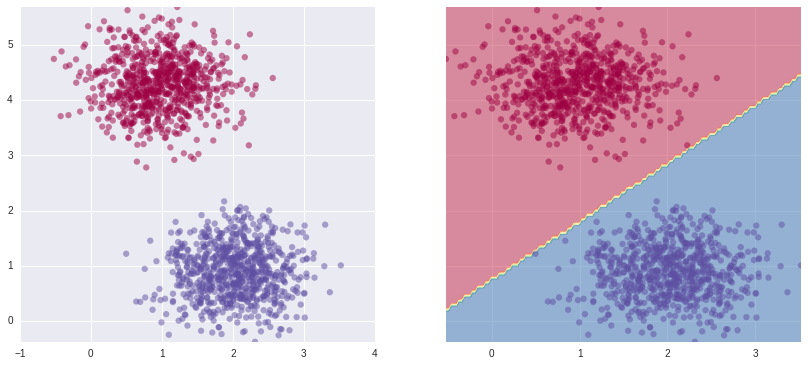

In [9]:
n_samples = 1500

X, y = make_blobs(n_samples=n_samples, centers=2, n_features=2, \
    cluster_std=0.5, random_state=0)

_, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,6))

ax1.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, edgecolors='none', s=40, cmap=plt.cm.Spectral)
  
coef = logistic_regression(X, y, 0.02, 750, False)

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 100))
Z = logistic_prediction(np.c_[xx.ravel(), yy.ravel()], coef)[1]
Z = Z.reshape(xx.shape)

ax2.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.Spectral)
ax2.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, edgecolors='none', cmap=plt.cm.Spectral, s=40)

plt.xlim(X[:, 0].min(), X[:, 0].max())
plt.ylim(X[:, 1].min(), X[:, 1].max())
plt.show()

In previous sections, we were using few unit test cases and in the very last section, we used our logistic regression implementation for training simple model against a small 2D dataset. 

So next we are going to build a simple logistic regression model using our logistic regression implementation. The dataset we use in this section is called, "**Census Income Data Set**" you can download in from  UC Irvine Machine Learning Repository [1]. First of all, let's load it using pandas library.

[1]. http://archive.ics.uci.edu/ml/datasets/Census+Income

In [10]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 
             'education-num', 'marital-status', 'occupation', 'relationship',
            'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', '<=50K']

data = pd.read_csv('./data/adult.data', index_col=False, names = col_names)
data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,<=50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In our dataset response variable is <=50K, but we need to change this feature to a binary representation.  So let's do this by using a simple lambda function as shown below.

In [11]:
data['target'] = data['<=50K'].apply(lambda x : 0 if x.strip() == '<=50K' else 1)
data = data.drop('<=50K', axis=1)

In [12]:
data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Now we have encoded the response variable of our dataset. But before building our model, let's check how many 0 and 1 responses available in our dataset. 

In [13]:
response_variable = data['target']
print 'No: of zeor responses: %d' %sum(response_variable == 0)
print 'No of one responses: %d' %sum(response_variable == 1)

## If we create a simple model which always predicts zero, you will get
print 'Performance of always zero model: %f' %(float(sum(response_variable == 0))/ 
                                              (sum(response_variable == 0) + sum(response_variable == 1)))

No: of zeor responses: 24720
No of one responses: 7841
Performance of always zero model: 0.759190


Let's build a simple linear regression model using a subset of features. Ideally, we would like to have a model which performs better than our "**always zero**" model.

In [15]:
numerical = ['age', 'education-num', 'hours-per-week']
categorical = ['education', 'workclass', 'race', 'sex', 'occupation', 'relationship', 'native-country']
simple_features = {'numerical': numerical, 'categorical' :categorical}
train_featues, train_lables, test_features, test_labels = train_test_split(data, 
                                                                          simple_features, 'target', 0.7)
coefficients = logistic_regression(train_featues, train_lables, 1.0e-8, 75000)
test_prediction =  logistic_prediction(test_features, coefficients)[1]

iteration     0: log likelihood of observed labels = 15015.37549508
iteration     1: log likelihood of observed labels = 14505.17944955
iteration     2: log likelihood of observed labels = 14169.97507399
iteration     3: log likelihood of observed labels = 13947.35042177
iteration     4: log likelihood of observed labels = 13797.81219899
iteration     5: log likelihood of observed labels = 13696.27627459
iteration     6: log likelihood of observed labels = 13626.64883484
iteration     7: log likelihood of observed labels = 13578.47441681
iteration     8: log likelihood of observed labels = 13544.87273924
iteration     9: log likelihood of observed labels = 13521.26057631
iteration    10: log likelihood of observed labels = 13504.55066710
iteration    11: log likelihood of observed labels = 13492.64269298
iteration    12: log likelihood of observed labels = 13484.09526325
iteration    13: log likelihood of observed labels = 13477.91166271
iteration    14: log likelihood of observed labe

OK, we need one little function to compute the prediction accuracy of our logistic regression models.

In [ ]:
def prediction_accuracy(actual, predicted):
    return sum(actual == predicted)/ float(len(actual))

In [ ]:
print 'prediction accuracy (test set): %f' %(prediction_accuracy(test_labels, test_prediction))

In our logistic regression implementation, the learning rate is known as a hyperparameter. So we are going to use K-fold cross-validation and grid search for finding the optimum value for learning rate. 

In [ ]:
traing_size = train_featues.shape[0]
learning_rates = [0.25e-6, 1.0e-7, 0.75e-7, 0.5e-7, 0.25e-7, 1.0e-8]
average_accuracies = []

best_cv_accuracy = 0.0
best_learning_rate = 0.0

for learning_rate in learning_rates:
    fold_accuracies = []
    for start_idx, end_idx in get_k_fold_indices(traing_size, 3):
        cv_test_features = train_featues[start_idx:end_idx+1]
        cv_train_features = np.row_stack((train_featues[0:start_idx], train_featues[end_idx+1:traing_size]))
        assert cv_test_features.shape[0] + cv_train_features.shape[0] == traing_size
        
        cv_test_labels = train_lables[start_idx:end_idx+1]
        cv_train_lables = np.hstack((train_lables[0:start_idx], train_lables[end_idx+1:traing_size]))
        assert cv_test_labels.shape[0] + cv_train_lables.shape[0] == traing_size
        
        coefficients = logistic_regression(cv_train_features, cv_train_lables, learning_rate, 10000, debug=False)
        cv_prediction =  logistic_prediction(cv_test_features, coefficients)[1]
        accuracy = prediction_accuracy(cv_test_labels, cv_prediction)
        fold_accuracies.append(accuracy)
        print 'prediction accuracy (cv set): %f' %(accuracy)
    
    average_accuracy = sum(fold_accuracies)/float(len(fold_accuracies))
    average_accuracies.append(average_accuracy)
    if best_cv_accuracy <  average_accuracy:
        best_cv_accuracy = average_accuracy
        best_learning_rate = learning_rate
    print 'average accuracy: %f for learning rate: %e' %(average_accuracy, learning_rate)
    
print '\nbest accuracy: %f for learning rate: %e' %(best_cv_accuracy, best_learning_rate)  

plt.xlim(0, 0.26e-6)
plt.ylim(0.7, 0.9)
plt.title('Learning reate vs. Prediction accuracy')
plt.scatter(learning_rates, average_accuracies, c='green')
plt.plot(learning_rates, average_accuracies, c='green')
plt.show()

print 'training the model with full dataset using the best hyper-parameters'
coefficients = logistic_regression(train_featues, train_lables, best_learning_rate, 75000)
test_prediction =  logistic_prediction(test_features, coefficients)[1]
print 'prediction accuracy (test set): %f' %(prediction_accuracy(test_labels, test_prediction))

## Conclusion
In this notebook, we discussed how to implement logistic regression algorithm from the scratch. In addition to that,  we implemented a simple logistic regression based predictive model using a real-world dataset. 
In the next notebook, we are going to discuss: regularization, handling large datasets and one more case study. 